# Fit Gaussian to Cs-137 Isotope Peak/Compton Edge

#### Din-Ammar Tolj - Y25
Maruyama Group, Summer 2023

This notebook fits a Gaussian to Cs-137 run in order to find a value for "sigma" which will be used in the smearing project. The decay rate is also calculated.

### Import needed libraries

In [1]:
import ROOT

import sys
import math

import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle, TCanvas
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel, ConstantModel
from datetime import datetime
from glob import glob

mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rc('font', family='serif', size=14)
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['ytick.major.size'] = 8

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['axes.linewidth'] = 1.2 # set the value globally

# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=22)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

# Import parser that Tom wrote. This is containted in the file named dt5202.py in this folder.
%cd /home/dt592/Geant4Work/gamma_sim/gamma_sim-build
from dt5202 import dt5202_crunch
# from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ
ped = 50 #pedestal correction

# Import Langaus fit curve for PyROOT.
from langaus import LanGausFit
%cd -
from root_numpy import array2hist, hist2array, fill_hist

Welcome to JupyROOT 6.24/02


/tmp/ipykernel_43815/13054003.py:29: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


/vast/palmer/home.grace/dt592/Geant4Work/gamma_sim/gamma_sim-build
/vast/palmer/home.grace/dt592/Geant4Work


### Declare constants (calculated with $\texttt{MuonPeakCalibration_Din_ThanksEmily_v1_cut.ipynb}$)

In [2]:
adc_mev_cs = 551.0348291637422
adc_mev_bkg = 583.9005065850638
adc_mev_bkg2min = 575.4041720670236

### Load and read lab data from directory

In [32]:
# Import data files
folder = "/home/dt592/data/"

sourceFolder_Cs = folder + "Cs-173-SwirlyDin1-10min-20230710/" #Caesium data
sourceFolder_bkg = folder + "BkgSwirlyDin1_10min_20230711/" #Background data
# sourceFolder_Eu = folder + "Eu-152-SwirlyDin1-2min-20230717/" #Europium data
# sourceFolder_Co57 = folder + "Co-57-SwirlyDin1-2min-20230717/" #Co-57
# sourceFolder_Co60 = folder + "Co-60-SwirlyDin1-2min-20230717/" #Co-60
# sourceFolder_bkg2min = folder + "swirlyPanel_2min_bkg/" #Bkg 2 min data

# Importing Ceasium data
onlyfiles_Cs = [f for f in os.listdir(sourceFolder_Cs) if '.dat' in f]
data_list_Cs = []
for file in onlyfiles_Cs:
    data_list_Cs.append(dt5202_crunch(str(sourceFolder_Cs)+str(file), num_ev=10000000, num_ch=1))

data_Cs = data_list_Cs[0]

for j in range(1, len(data_list_Cs)):
    data_Cs = np.append(data_Cs, data_list_Cs[j])
    
# Importing Bkground to Filter out the Caesium Peak
onlyfiles_bkg = [f for f in os.listdir(sourceFolder_bkg) if '.dat' in f]
data_list_bkg = []
for file in onlyfiles_bkg:
    data_list_bkg.append(dt5202_crunch(str(sourceFolder_bkg)+str(file), num_ev=10000000, num_ch=1))

data_bkg = data_list_bkg[0]

for k in range(1, len(data_list_bkg)):
    data_bkg = np.append(data_bkg, data_list_bkg[k])
    
# # Importing 2 min Bkground
# onlyfiles_bkg2min = [f for f in os.listdir(sourceFolder_bkg2min) if '.dat' in f]
# data_list_bkg2min = []
# for file in onlyfiles_bkg2min:
#     data_list_bkg2min.append(dt5202_crunch(str(sourceFolder_bkg2min)+str(file), num_ev=10000000, num_ch=1))

# data_bkg2min = data_list_bkg2min[0]

# for l in range(1, len(data_list_bkg2min)):
#     data_bkg2min = np.append(data_bkg2min, data_list_bkg2min[l])

[(259, [3, 0, 3], 1, 0, 288, 0.5, 1689019979043)]
((33, 0, 1.68901998e+09, 0, 256), (8, 3, 267, 2716))
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1689087020711)]
((33, 0, 1.68908702e+09, 0, 256), (8, 3, 3394, 8083))


In [34]:
# Convert data from ADC to MeV

cs_mev = (data_Cs['data']['low_gain']-ped) / adc_mev_cs # Cesium data
bkg_mev = (data_bkg['data']['low_gain']-ped) / adc_mev_bkg # Background
# bkg2min_mev = (data_bkg2min['data']['low_gain']-ped) / adc_mev_bkg2min # Background (2 min)

### Plot Cs-137 Data, Fit Gaussian in PyROOT

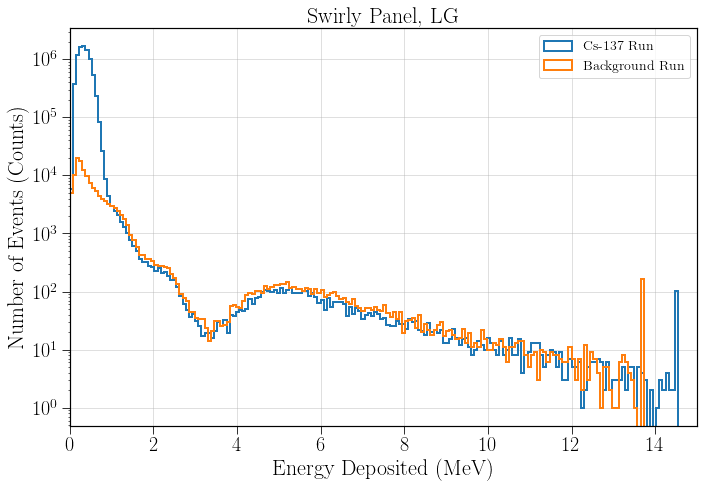

In [35]:
plt.figure(figsize=(10,7))
plt.hist(cs_mev, bins=200, range=(0,15), histtype='step', label = "Cs-137 Run", lw = 2)
plt.hist(bkg_mev, bins=200, range=(0,15), histtype='step', label = "Background Run", lw = 2)

# Estimation of Cs-137 peak?
# plt.axvline(0.23,color='red')
# plt.axvline(0.58,color='red')

plt.yscale('log')
plt.xlabel('Energy Deposited (MeV)')
plt.ylabel('Number of Events (Counts)')
plt.title('Swirly Panel, LG')
plt.legend()
plt.grid(alpha = 0.5)
plt.tight_layout()
plt.xlim(0,15)

# plt.savefig("Cs137wBg.jpg")
plt.show()

 FCN=981.028 FROM MIGRAD    STATUS=CONVERGED      72 CALLS          73 TOTAL
                     EDM=9.84404e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.4 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.58821e+05   2.08097e+02  -3.63435e+00  -2.62925e-06
   2  Mean         3.17151e-01   1.50669e-04   9.48862e-06  -3.71388e+00
   3  Sigma        1.60073e-01   1.09917e-04  -1.35415e-06  -9.25851e+00


/gpfs/gibbs/project/maruyama/dt592/conda_envs/ROOT6/lib/python3.8/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h1(
/gpfs/gibbs/project/maruyama/dt592/conda_envs/ROOT6/lib/python3.8/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

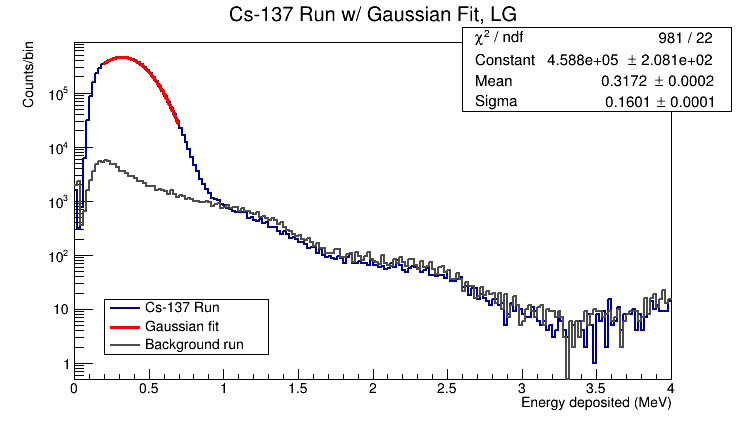

In [48]:
# Turn cs_mev into a ROOT Histogram
c1 = ROOT.TCanvas('c1','', 200, 10, 750, 450)
cs_hpx = ROOT.TH1D('Gaussian Fit', 'Cs-137 Run w/ Gaussian Fit, LG', 200, 0, 4)
bkg_hpx = ROOT.TH1D('bkg', 'bkg', 200, 0, 4)
fill_hist(cs_hpx, cs_mev)
fill_hist(bkg_hpx, bkg_mev)

# Define Gaussian as a custom function, this will be convenient later
gaussian = ROOT.TF1("gaussian","[0] * exp((-(x-[1])**2)/(2*[2]**2))", 0.2, 0.7)
gaussian.SetParameters(2.8*10**5, 0.3, 0.15)
gaussian.SetParNames("Constant", "Mean", "Sigma")
gaussian.SetTitle("Gaussian Fit")

# Draw the function
cs_hpx.Draw()
cs_hpx.GetXaxis().SetTitle("Energy deposited (MeV)")
cs_hpx.GetYaxis().SetTitle("Counts/bin")
ROOT.gPad.SetLogy()
# ROOT.gPad.SetGrid()
ROOT.gStyle.SetOptStat(0)
cs_hpx.Fit("gaussian","R")
# gaussian.SetLineWidth()
gaussian.Draw("same")
gaussian.SetLineWidth(3)
ROOT.gStyle.SetOptFit()
bkg_hpx.Draw("same")
cs_hpx.SetLineWidth(2)
# cs_hpx.SetLineColor(9)

bkg_hpx.SetLineColor(12)
bkg_hpx.SetLineWidth(2)

legend = ROOT.TLegend(0.14,0.16,0.36,0.29)
legend.AddEntry(cs_hpx,"Cs-137 Run","l")
legend.AddEntry(gaussian,"Gaussian fit","l")
legend.AddEntry(bkg_hpx,"Background run","l")
legend.Draw()

c1.Draw()
# c1.SaveAs("Cs137GaussFit_vz3.png")

In [36]:
binWidth = cs_hpx.GetBinWidth(1)
print(binWidth)
cs_dr = (gaussian.Integral(0.2, 0.7))/(10*60*binWidth)
print("Decay rate of Cs-137 source: %0.3f/sec"%cs_dr)

0.011000000000000001
Decay rate of Cs-137 source: 11636.944/sec


NOTE: Pause for now, ran into complication with the way Cs-137 source decays. Talk to Jorge to see where to go from here. Value of sigma is good though!